# Sessa Empirical Estimator

## Setup

### Import Libraries and Set Paths

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# DBScan Libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

CSV_PATH = './csv-files/'

### Setup sample data

In [164]:
file_path = CSV_PATH + "med_events.csv"

# Try to read the CSV file into a DataFrame
try:
    med_events = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    
    # Convert date column to datetime (assuming 'DATE' is the column name in your CSV)
    med_events["DATE"] = pd.to_datetime(med_events["DATE"])

    # Display the first few rows
    print(med_events.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")



CSV file loaded successfully!
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION
0          28 2022-05-23       6     medB        35
1          80 2021-07-15       2     medC         5
2          22 2021-04-28       6     medB        17
3           9 2020-05-14       9     medC        46
4           5 2021-02-25      10     medB        30


## Callable Functions

In [165]:
# Define the function equivalent to See()
def see(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["CATEGORY"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["PATIENT_ID", "DATE"]).copy()
    subset["prev_DATE"] = subset.groupby("PATIENT_ID")["DATE"].shift(1)
    
    # Remove rows where prev_DATE is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("PATIENT_ID").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["DATE"] - subset["prev_DATE"]).dt.days
    
    # Compute ECDF
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Density plot of log-transformed event intervals
    kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
    x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                         max(np.log(subset_filtered["event_interval"])), 100)
    y_vals = kde(x_vals)

    # Silhouette Analysis
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(x_vals.reshape(-1, 1))

    best_clusters = []
    best_score = -1
    best_k = 2
    
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        best_clusters.append((k, score))
        if score > best_score:
            best_score = score
            best_k = k

    # K-means Clustering
    subset_filtered = subset_filtered.copy()  # Ensure a fresh copy before modification
    subset_filtered.loc[:, "cluster"] = KMeans(n_clusters=best_k, random_state=1234, n_init=10).fit_predict(subset_filtered[["event_interval"]])

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()
    
    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = med_events.copy()  # Ensure we're not modifying the original dataset
    final_result = final_result.merge(results[["PATIENT_ID", "median", "cluster"]], on="PATIENT_ID", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result

In [166]:
# Define the function equivalent to See() using DBSCAN
def see_dbscan(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["CATEGORY"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["PATIENT_ID", "DATE"]).copy()
    subset["prev_DATE"] = subset.groupby("PATIENT_ID")["DATE"].shift(1)
    
    # Remove rows where prev_DATE is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("PATIENT_ID").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["DATE"] - subset["prev_DATE"]).dt.days
    
    # Compute ECDF
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Density plot of log-transformed event intervals
    kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
    x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                         max(np.log(subset_filtered["event_interval"])), 100)
    y_vals = kde(x_vals)

    # Normalize the data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_filtered[["event_interval"]])

    # Determine the optimal epsilon (eps) using k-distance method
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(scaled_data)
    distances, _ = neigh.kneighbors(scaled_data)
    k_distances = np.sort(distances[:, -1])  # Take the 5th neighbor distance

    # Choose eps as the "knee" point (approximation: 90th percentile of distances)
    eps_value = np.percentile(k_distances, 90)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    subset_filtered.loc[:, "cluster"] = dbscan.fit_predict(scaled_data)

    # Handle noise points (DBSCAN assigns -1 to noise)
    subset_filtered.loc[subset_filtered["cluster"] == -1, "cluster"] = np.nan

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = med_events.copy()  # Ensure we're not modifying the original dataset
    final_result = final_result.merge(results[["PATIENT_ID", "median", "cluster"]], on="PATIENT_ID", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result


In [167]:
# Define function equivalent to see_assumption()
def see_assumption(data):
    data = data.copy()
    
    # Sort and create previous prescription date column
    data.sort_values(["PATIENT_ID", "DATE"], inplace=True)
    data["prev_DATE"] = data.groupby("PATIENT_ID")["DATE"].shift(1)
    
    # Remove rows where prev_DATE is NaN
    data = data.dropna()
    
    # Compute duration between prescriptions
    data["duration"] = (data["DATE"] - data["prev_DATE"]).dt.days
    
    # Assign sequence number per patient
    data["p_number"] = data.groupby("PATIENT_ID").cumcount() + 1
    
    # Filter only patients with at least 2 prescriptions
    data = data[data["p_number"] >= 2]
    
    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data["p_number"], y=data["duration"])
    plt.title("Duration Between Prescriptions")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    
    # Compute median of medians per patient
    medians_of_medians = data.groupby("PATIENT_ID")["duration"].median()
    
    # Overlay median line
    plt.axhline(medians_of_medians.median(), color="red", linestyle="dashed")
    plt.show()


## Execution

### Using K-Means

In [168]:
med_a = see("medA")
med_a


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION,median,cluster
0,28,2022-05-23,6,medB,35,70.0,0.0
1,80,2021-07-15,2,medC,5,70.0,0.0
2,22,2021-04-28,6,medB,17,70.0,1.0
3,9,2020-05-14,9,medC,46,70.0,0.0
4,5,2021-02-25,10,medB,30,263.0,0.0
...,...,...,...,...,...,...,...
1075,99,2022-10-21,4,medA,45,263.0,0.0
1076,44,2020-08-16,5,medB,20,70.0,0.0
1077,49,2020-04-21,9,medC,35,263.0,0.0
1078,14,2020-06-29,2,medA,36,70.0,1.0


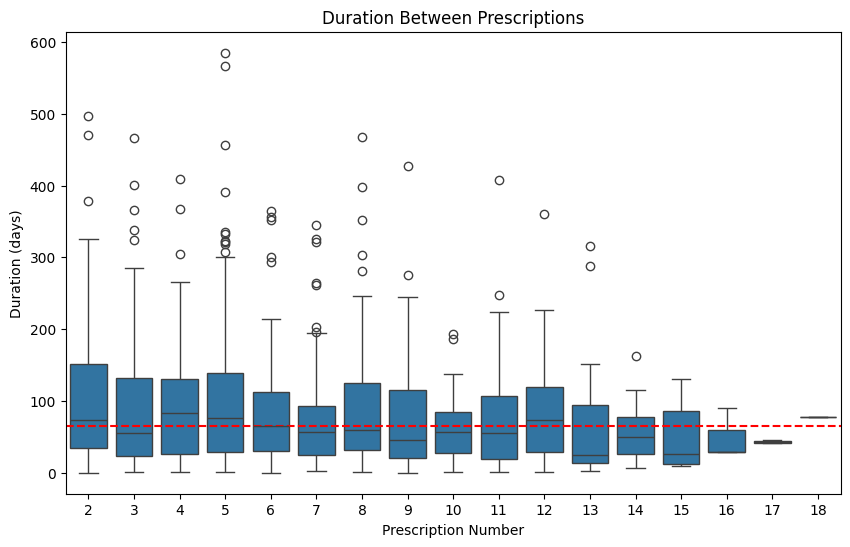

In [169]:
see_assumption(med_a)

In [170]:
med_b = see("medB")
med_b

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION,median,cluster
0,28,2022-05-23,6,medB,35,99.0,0.0
1,80,2021-07-15,2,medC,5,270.0,1.0
2,22,2021-04-28,6,medB,17,99.0,0.0
3,9,2020-05-14,9,medC,46,99.0,0.0
4,5,2021-02-25,10,medB,30,270.0,1.0
...,...,...,...,...,...,...,...
1075,99,2022-10-21,4,medA,45,99.0,0.0
1076,44,2020-08-16,5,medB,20,270.0,1.0
1077,49,2020-04-21,9,medC,35,99.0,0.0
1078,14,2020-06-29,2,medA,36,270.0,1.0


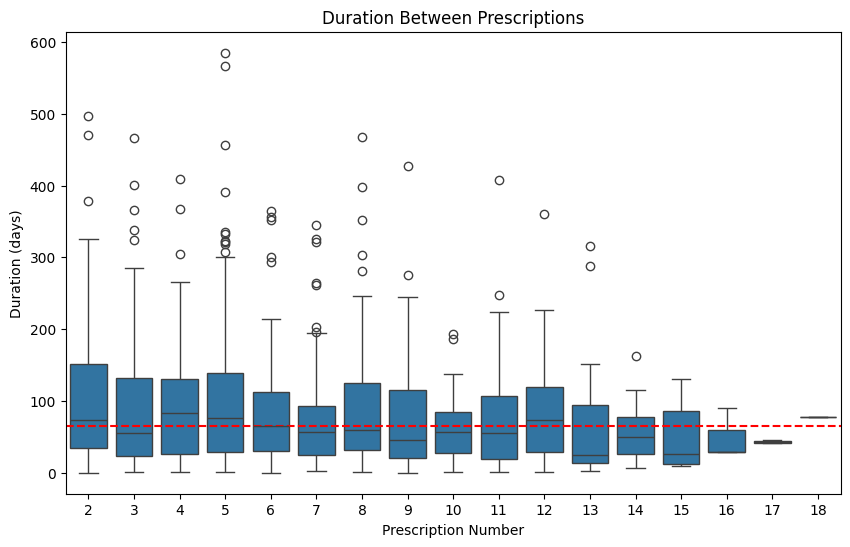

In [171]:
see_assumption(med_b)

### Using DBScan

In [172]:
med_c = see_dbscan("medC")
med_c

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION,median,cluster
0,28,2022-05-23,6,medB,35,52.0,1.0
1,80,2021-07-15,2,medC,5,52.0,1.0
2,22,2021-04-28,6,medB,17,203.0,0.0
3,9,2020-05-14,9,medC,46,127.5,0.0
4,5,2021-02-25,10,medB,30,127.5,0.0
...,...,...,...,...,...,...,...
1075,99,2022-10-21,4,medA,45,203.0,0.0
1076,44,2020-08-16,5,medB,20,127.5,0.0
1077,49,2020-04-21,9,medC,35,203.0,0.0
1078,14,2020-06-29,2,medA,36,52.0,1.0


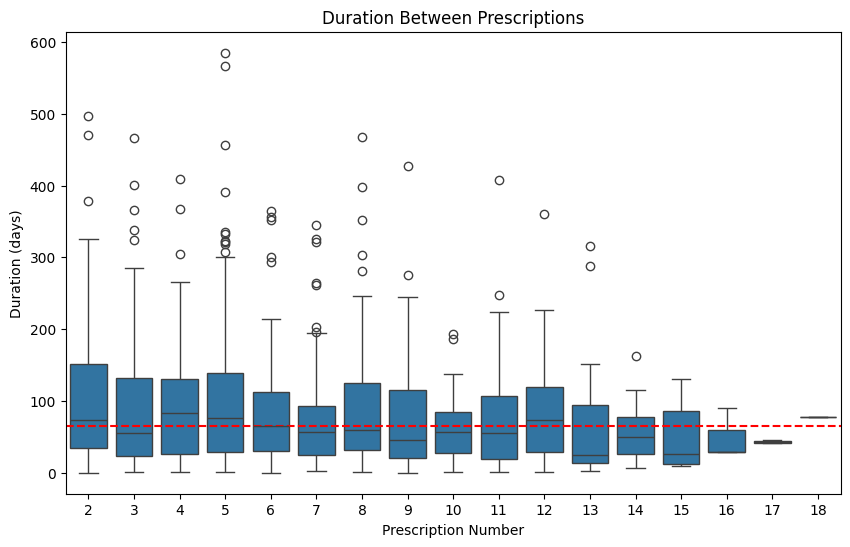

In [173]:
see_assumption(med_c)